In [1]:
import csv
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import itertools as it
import numpy.matlib as nm
from sklearn import metrics
import sklearn.model_selection as ms
import sklearn.metrics as metrics
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn import linear_model
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn 
from scipy.stats import poisson
import statsmodels.api as sm
from numpy import random as rn
from scipy import stats
from fitter import Fitter, get_common_distributions
from scipy.stats import weibull_max
from tqdm import tqdm
from scipy.integrate import quad
from ipywidgets import interact, FloatSlider, IntSlider
import scipy.interpolate as interp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
short_rates = pd.read_csv('short_rates.csv', sep=';', decimal=',')
short_rates[:2506]

,tradedate,tradetime,period_0.25
0,06.01.2014,12:21:16,5.92
1,08.01.2014,12:41:22,5.92
2,09.01.2014,18:38:19,5.78
3,10.01.2014,18:38:17,5.70
4,13.01.2014,18:37:26,5.81
...,...,...,...
2501,25.12.2023,18:39:59,13.78
2502,26.12.2023,18:39:59,13.33
2503,27.12.2023,18:39:57,13.22
2504,28.12.2023,18:39:57,12.78


Time interval: δt=0.08333333333333333 years
Simulation path M=1000000


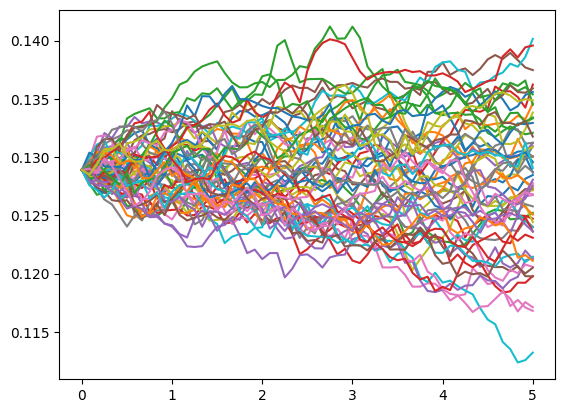

The expected value for the interest rate is: 12.769%
The standard error of sample mean is: 0.0006%
Lower 99% is: 12.767%
Upper 99% is: 12.770%


In [3]:
'''Parameters a, b, σ for Cox-Ingersoll-Ross colibrated in excel: CIR_Calibration.xlsx'''

a = 0.004924420
b = 0.079128172
σ = 0.007782762

r0 = 0.1289  # as of 03.01.2024
T = 5
N = 60
δt = T/N
print(f"Time interval: δt={δt} years")
M = 1000000
print(f"Simulation path M={M}")
dz = rn.randn(M,N)
r = r0*np.ones((M,N+1))
for i in range(0,N):
    r[:,i+1] = r[:,i] + a*(b-r[:,i])*δt + σ*np.sqrt(r[:,i])*dz[:,i]*np.sqrt(δt)
plt.show()

a = [ rn.randint(0,M) for j in range(1,60)]

for runer in a:
    plt.plot(np.arange(0,T+δt,δt),r[runer])
plt.show()
V = (r[:,-1])
print("The expected value for the interest rate is:","{:.3%}".format(np.mean(V)))
print("The standard error of sample mean is:", "{:.4%}".format(np.std(V)/np.sqrt(M)))
from scipy.stats import norm
def normsinv(x):
    x = norm.ppf(x)
    return (x)

z = normsinv(0.995)
μ = np.mean(V)
SE = np.std(V)/np.sqrt(M)

print("Lower 99% is:","{:.3%}".format( (μ-z*SE) ))
print("Upper 99% is:","{:.3%}".format( (μ+z*SE) ))

In [4]:
a = 0.004924420
b = 0.079128172
σ = 0.007782762

r0 = 0.1289  # as of 03.01.2024
T = 5
N = 60
δt = 0.08333333333333333
M = 1000000
dz = rn.randn(M,N)
r = r0*np.ones((M,N+1))

for i in range(0,N):
    r[:,i+1] = r[:,i] + a*(b-r[:,i])*δt + σ*np.sqrt(r[:,i])*dz[:,i]*np.sqrt(δt)

rate = []
years = []
for i in range(0,61):
    rate.append(np.mean(r[:,i]))
    years.append(i/12)

In [5]:
df = pd.read_excel(io='Data.xlsx',sheet_name='SibFD', usecols = 'A:DK')
df.head(101)

,region,t_2003,n_2003,b_2003,d_2003,inj_2003,pr_2003,t_2004,n_2004,b_2004,...,b_2021,d_2021,inj_2021,pr_2021,t_2022,n_2022,b_2022,d_2022,inj_2022,pr_2022
0,Республика Алтай,2,3,0,0,1479,0,1,6,1,...,0,5,693,78.389,0,0,0,0,0,0.000000
1,Республика Тыва,0,17,0,0,172,0,7,1,0,...,1,19,138,155.539,0,4,0,0,0,52.993300
2,Республика Хакасия,1,1,0,2,313,0,3,0,0,...,0,1,1486,21.214,1,0,0,3,3,0.000000
3,Алтайский край,2,0,0,7,60,0,22,2,0,...,0,8,20,0.000,1,0,0,2,2,0.100000
4,Красноярский край,9,23,0,8,415,0,17,5,0,...,0,16,25,0.415,5,0,0,4,14,0.000000
5,Иркутская область,7,20,0,15,9,0,24,2,0,...,0,22,1768,195.518,3,2,0,3,476,105.420471
6,Кемеровская область,14,2,0,39,57,0,29,1,1,...,0,55,176,30.000,3,0,0,3,6,0.000000
7,Новосибирская область,4,0,0,11,14,0,13,0,1,...,0,0,0,0.000,3,0,0,1,13,0.900000
8,Омская область,5,0,1,12,74,0,17,4,0,...,0,4,11,249.788,3,0,0,0,200,153.779030
9,Томская область,3,0,0,11,2,0,6,2,0,...,0,0,0,0.000,1,0,0,0,16,0.000000


In [7]:
df.describe()

,t_2003,n_2003,b_2003,d_2003,inj_2003,pr_2003,t_2004,n_2004,b_2004,d_2004,...,b_2021,d_2021,inj_2021,pr_2021,t_2022,n_2022,b_2022,d_2022,inj_2022,pr_2022
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000
mean,4.700000,6.600000,0.100000,10.500000,259.500000,0.0,13.900000,2.300000,0.300000,39.800000,...,0.100000,13.000000,431.700000,73.086300,2.000000,0.600000,0.0,1.600000,73.000000,31.319280
std,4.270051,9.406853,0.316228,11.286669,450.483999,0.0,9.492102,2.057507,0.483046,34.064644,...,0.316228,16.806084,666.815492,93.626138,1.632993,1.349897,0.0,1.577621,154.184594,55.539378
min,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,1.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,3.250000,24.750000,0.0,6.250000,1.000000,0.000000,15.250000,...,0.000000,1.750000,13.250000,0.103750,1.000000,0.000000,0.0,0.000000,2.250000,0.000000
50%,3.500000,1.500000,0.000000,9.500000,67.000000,0.0,15.000000,2.000000,0.000000,35.000000,...,0.000000,6.500000,81.500000,25.607000,2.000000,0.000000,0.0,1.500000,9.500000,0.050000
75%,6.500000,13.500000,0.000000,11.750000,277.750000,0.0,20.750000,3.500000,0.750000,53.500000,...,0.000000,18.250000,563.750000,136.251500,3.000000,0.000000,0.0,3.000000,15.500000,39.969975
max,14.000000,23.000000,1.000000,39.000000,1479.000000,0.0,29.000000,6.000000,1.000000,119.000000,...,1.000000,55.000000,1768.000000,249.788000,5.000000,4.000000,0.0,4.000000,476.000000,153.779030


In [23]:
'''Number of Technogenic and Natural in each year'''
t_n = []

t_n.append(sum(df["t_2022"]+df["n_2022"]))
t_n.append(sum(df["t_2021"]+df["n_2021"]))
#t_n.append(sum(df["t_2020"]+df["n_2020"]))
t_n.append(sum(df["t_2019"]+df["n_2019"]))
t_n.append(sum(df["t_2018"]+df["n_2018"]))
t_n.append(sum(df["t_2017"]+df["n_2017"]))
t_n.append(sum(df["t_2016"]+df["n_2016"]))
t_n.append(sum(df["t_2015"]+df["n_2015"]))
t_n.append(sum(df["t_2014"]+df["n_2014"]))

'''Claim size'''

ips = [1.1077, 1.1159, 1.0500, 1.0196, 1.0428, 1.0358, 1.0474, 1.0910, 1.1220] # inflation in region 

pr = []

pr.append(sum(df["pr_2022"])*math.prod(ips[8:]))
pr.append(sum(df["pr_2021"])*math.prod(ips[7:]))
#pr.append(sum(df["pr_2020"])*math.prod(ips[6:]))
pr.append(sum(df["pr_2019"])*math.prod(ips[5:]))
pr.append(sum(df["pr_2018"])*math.prod(ips[4:]))
pr.append(sum(df["pr_2017"])*math.prod(ips[3:]))
pr.append(sum(df["pr_2016"])*math.prod(ips[2:]))
pr.append(sum(df["pr_2015"])*math.prod(ips[1:]))
pr.append(sum(df["pr_2014"])*math.prod(ips))

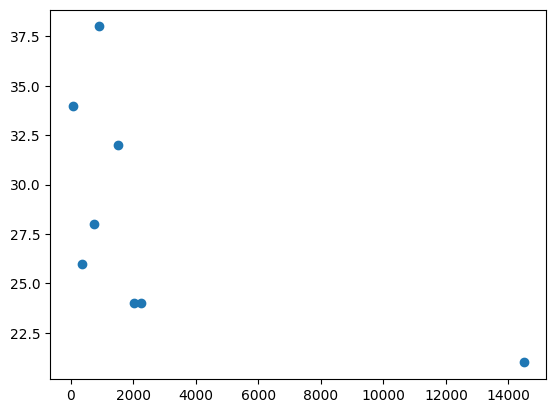

In [24]:
plt.scatter(pr, t_n)

In [25]:
np.mean(t_n)

28.375

In [26]:
'''average claim size for one disaster'''
one_pr = [int(p) / int(t) for p,t in zip(pr, t_n)]
print(one_pr)
np.mean(one_pr)

[13.5, 23.526315789473685, 2.1176470588235294, 47.21875, 84.45833333333333, 93.33333333333333, 26.857142857142858, 690.0]


122.62644029651334

2024-05-10 01:11:19.912 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.002205)
2024-05-10 01:11:19.942 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.002336)
2024-05-10 01:11:19.943 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.003015)
2024-05-10 01:11:19.986 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.002416)
2024-05-10 01:11:19.989 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.002216)
2024-05-10 01:11:19.991 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.002938)
2024-05-10 01:11:20.007 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.003091)
2024-05-10 01:11:20.060 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted 

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
genextreme,0.002032,1605.180831,1605.419155,inf,0.133641,0.994335
t,0.002147,1765.921092,1766.159416,inf,0.251632,0.605687
exponpow,0.002200,1489.685580,1489.923904,inf,0.278531,0.481324
cauchy,0.002205,1786.767672,1786.926555,inf,0.248388,0.621069
gamma,0.002216,1562.672090,1562.910415,inf,0.252394,0.602082


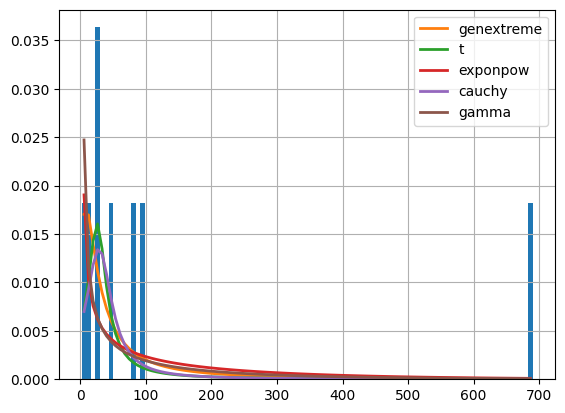

In [27]:
from fitter import Fitter, get_common_distributions


#Organize Data - from question
SR_y = pd.Series(one_pr, name="one_pr (Target Vector Distribution)")


# fitter
distributions_set = get_common_distributions()
distributions_set.extend(['arcsine', 'cosine', 'expon', 'weibull_max', 'weibull_min', 
                          'dweibull', 't', 'pareto', 'exponnorm', 'lognorm',
                          "norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"])  

f = Fitter(SR_y, distributions = distributions_set) 
f.fit()
f.summary()

In [28]:
f.fitted_param

{'norm': (122.62644029651334, 216.60375941448476),
 'expon': (2.1176470588235294, 120.5087932376898),
 'cauchy': (28.286931026966325, 23.600884396606247),
 'powerlaw': (0.1341188878403873, 2.117647058823529, 687.8823529411766),
 'rayleigh': (-167.61546966123777, 256.083536066272),
 'gamma': (0.33831417208424797, 2.117647058823529, 275.39841117340677),
 'uniform': (2.1176470588235294, 687.8823529411765),
 'cosine': (187.56428003427055, 209.70646835003961),
 'chi2': (0.2975500747942339, 2.117647058823529, 227.49977015084022),
 'lognorm': (5.83957081443803, 2.117647058823473, 2.9107677112468133),
 'exponpow': (0.4537943403595488, 2.117647058823529, 239.08541222451345),
 'arcsine': (-65.95006231315999, 755.9500623131601),
 'weibull_max': (0.14612064889698573, 690.0000000000001, 1.7272292726198406),
 'pareto': (285122249.2461905, -34359738365.882355, 34359738368.0),
 'weibull_min': (0.48012098938213466, 2.117647058823529, 243.7559682726515),
 'dweibull': (0.40614140048207703, 23.52631578947

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


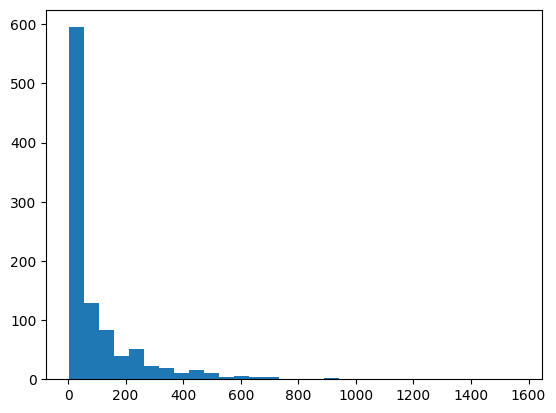

In [29]:
from scipy.stats import gamma

r = gamma.rvs(0.33831417208424797, 2.117647058823529, 275.39841117340677, size=1000)

abs_r = []

for i in r:
    if i >= 0:
        abs_r.append(i)
    if i < 0:
        abs_r.append(0)
        
plt.hist(abs_r, bins=30, histtype="stepfilled")
#plt.set_xlim([x[0], x[-1]])
plt.legend(loc='best', frameon=False)
plt.show()

((array([-3.19758950e+00, -2.93237785e+00, -2.78437841e+00, -2.67999560e+00,
         -2.59855946e+00, -2.53139899e+00, -2.47402263e+00, -2.42379214e+00,
         -2.37902149e+00, -2.33856546e+00, -2.30160949e+00, -2.26755284e+00,
         -2.23593934e+00, -2.20641415e+00, -2.17869564e+00, -2.15255643e+00,
         -2.12781017e+00, -2.10430217e+00, -2.08190261e+00, -2.06050135e+00,
         -2.04000420e+00, -2.02032992e+00, -2.00140792e+00, -1.98317650e+00,
         -1.96558137e+00, -1.94857451e+00, -1.93211325e+00, -1.91615948e+00,
         -1.90067901e+00, -1.88564107e+00, -1.87101783e+00, -1.85678408e+00,
         -1.84291686e+00, -1.82939524e+00, -1.81620005e+00, -1.80331371e+00,
         -1.79072004e+00, -1.77840415e+00, -1.76635224e+00, -1.75455157e+00,
         -1.74299028e+00, -1.73165738e+00, -1.72054262e+00, -1.70963644e+00,
         -1.69892989e+00, -1.68841463e+00, -1.67808281e+00, -1.66792707e+00,
         -1.65794051e+00, -1.64811661e+00, -1.63844924e+00, -1.62893261e+00,

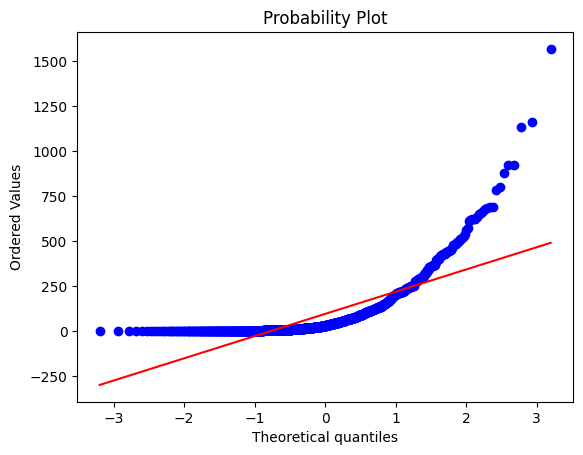

In [30]:
stats.probplot(abs_r, plot=plt)

# ALL years

In [31]:
claims = {}
for t in tqdm(years):
    claims_t = []
    for i in range(10000):
        rvs = poisson.rvs(28.333333333333332*t)*gamma.rvs(0.33831417208424797, 2.117647058823529, 275.39841117340677)
        if rvs >= 0:
            claims_t.append(rvs)
        if rvs < 0:
            claims_t.append(0)
        claims[f'X_{t}'] = claims_t

100%|███████████████████████████████████████████| 61/61 [00:29<00:00,  2.03it/s]


In [32]:
sorted_claims = {k: sorted(v) for k, v in claims.items()}

In [33]:
len(sorted_claims['X_0.0'])

10000

In [34]:
cdf_all = pd.DataFrame(sorted_claims)
cdf_all

,X_0.0,X_0.08333333333333333,X_0.16666666666666666,X_0.25,X_0.3333333333333333,X_0.4166666666666667,X_0.5,X_0.5833333333333334,X_0.6666666666666666,X_0.75,...,X_4.25,X_4.333333333333333,X_4.416666666666667,X_4.5,X_4.583333333333333,X_4.666666666666667,X_4.75,X_4.833333333333333,X_4.916666666666667,X_5.0
0,0.0,0.000000,0.000000,0.000000,0.000000,4.783788,10.722046,12.997649,12.705957,15.234304,...,183.030106,186.763968,205.780947,188.674998,203.298680,220.018398,208.387403,203.305562,223.866136,218.000779
1,0.0,0.000000,0.000000,0.000000,3.254774,7.343185,11.926038,14.866953,14.846734,19.058824,...,184.783997,190.588292,210.782746,199.011090,212.236157,222.352942,216.440419,222.356197,224.105623,226.976490
2,0.0,0.000000,0.000000,0.000000,4.237270,7.473713,12.425275,14.961369,15.284573,19.122276,...,186.359400,191.162693,213.898085,199.532434,214.083463,224.499958,222.910302,222.476600,225.015553,234.366516
3,0.0,0.000000,0.000000,0.000000,4.615029,8.470611,12.707819,14.966392,18.952392,21.562864,...,197.333568,196.961951,213.900628,201.533536,216.000002,227.377038,224.798369,230.474376,229.561443,237.178859
4,0.0,0.000000,0.000000,0.000000,5.486872,8.478424,12.713974,14.986484,19.059892,22.183678,...,201.811450,198.576157,213.901987,203.694708,216.091937,227.672400,227.801327,230.858327,230.823561,237.367629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,5887.564050,9057.317346,13630.033645,16973.759887,20492.319477,23824.343056,30382.928619,29232.741386,37109.537959,...,193680.452560,178368.082173,188564.504064,206851.825052,205575.902887,193290.211476,199005.576946,196632.958836,199375.804564,185322.411596
9996,0.0,6181.532640,9085.428847,13899.044587,17175.163096,20754.572884,24143.491661,30437.863076,31075.969515,39569.471699,...,197794.279379,235199.075546,207128.563640,215641.199317,214980.934734,201656.095153,213194.493576,206072.897104,221105.805782,222593.439444
9997,0.0,7851.653124,9153.212990,14379.420391,17400.245177,24079.565032,25218.628538,32318.526281,32661.231279,41593.417251,...,198689.651489,235950.357461,208065.243229,220483.104650,216397.898938,210399.208906,226229.117972,230864.270844,262295.146708,222673.888694
9998,0.0,9913.953010,9480.072277,16075.145151,18237.840944,24190.515486,28680.238578,50996.500106,50866.733060,41788.742210,...,205002.970542,268456.102597,208659.353412,310660.637453,220044.719303,212779.317472,272595.099193,232077.497221,287029.473064,263863.475104


In [35]:
def integrand(x):
    return a

prob = []

for i in range(1,10001):
    prob.append(i/10000)

for i in years:
    cdf_all[f'prob_{i}'] = prob
    
for i in years:
    cdf_all[f'prob_{i}'][(cdf_all[f'X_{i}']==0)] = 0

n= -1
for i in years:
    n+=1
    cdf_all[f'rate_{i}'] = rate[n]

n= -1
for i in years:
    n+=1
    a = rate[n]
    cdf_all[f'discount_{i}'] = math.exp(-quad(integrand, 0, i)[0])

for i in years:
    cdf_all[f'V_{i}'] = cdf_all[f'discount_{i}']*cdf_all[f'prob_{i}']

/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_97221/548078112.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf_all[f'rate_{i}'] = rate[n]
/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_97221/548078112.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf_all[f'rate_{i}'] = rate[n]
/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_97221/548078112.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

In [36]:
X_0 = []
Y_0 = []
Z_0 = []

for i in years:
    for n in cdf_all[f'X_{i}'].tolist():
        X_0.append(n)

for i in years:
    for n in cdf_all[f'V_{i}'].tolist():
        Y_0.append(n)

for i in years:
    for n in range(10000):
        Z_0.append(i)

In [37]:
X = X_0
Y = Y_0
Z = Z_0

plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),10),np.linspace(np.min(Y),np.max(Y),10))
plotz = interp.griddata((X,Y),Z,(plotx,ploty),method='linear')


@interact(elev=IntSlider(min=-180, max=180, step=10, value=30, continuous_update=False), azim=IntSlider(min=-180, max=180, step=10, value=30, continuous_update=False))
def plot_3d(elev, azim):
    #Figure settings
    fig = plt.figure(figsize=(10, 10))
    
    ax = fig.add_subplot(111, projection='3d')
    #Display 3D graph
    ax.plot_surface(plotx,plotz,ploty,cstride=1,rstride=1,cmap='viridis')
    ax.set_xlabel('D (критический уровень триггера)') 
    ax.set_ylabel('T (срок, лет)') 
    ax.set_zlabel('V (Стоимость) ')
    
    #Set the initial value of the viewing direction of the 3D graph
    ax.view_init(elev=elev, azim=azim)
    plt.show()

interactive(children=(IntSlider(value=30, continuous_update=False, description='elev', max=180, min=-180, step…

In [38]:
# Expected loss 2%
s_2 = round(((1/cdf_all['V_2.0'][9800])**(1/2)-1-0.1255)*100, 3)
s_3 = round(((1/cdf_all['V_3.0'][9800])**(1/3)-1-0.1216)*100, 3)
s_4 = round(((1/cdf_all['V_4.0'][9800])**(1/4)-1-0.1192)*100, 3)

print('Expected loss 2%')
print(round(cdf_all['X_2.0'][9800], 3), round(cdf_all['X_3.0'][9800], 3), round(cdf_all['X_4.0'][9800], 3))
print(round(cdf_all['V_2.0'][9800], 4), round(cdf_all['V_3.0'][9800], 4), round(cdf_all['V_4.0'][9800], 4))
print(s_2, s_3, s_4)
print()

# Expected loss 2,5%
s_2 = round(((1/cdf_all['V_2.0'][9750])**(1/2)-1-0.1255)*100, 3)
s_3 = round(((1/cdf_all['V_3.0'][9750])**(1/3)-1-0.1216)*100, 3)
s_4 = round(((1/cdf_all['V_4.0'][9750])**(1/4)-1-0.1192)*100, 3)
print('Expected loss 2,5%')
print(round(cdf_all['X_2.0'][9750], 3), round(cdf_all['X_3.0'][9750], 3), round(cdf_all['X_4.0'][9750], 3))
print(round(cdf_all['V_2.0'][9750], 4), round(cdf_all['V_3.0'][9750], 4), round(cdf_all['V_4.0'][9750], 4))
print(s_2, s_3, s_4)
print()

# Expected loss 3%
s_2 = round(((1/cdf_all['V_2.0'][9700])**(1/2)-1-0.1255)*100, 3)
s_3 = round(((1/cdf_all['V_3.0'][9700])**(1/3)-1-0.1216)*100, 3)
s_4 = round(((1/cdf_all['V_4.0'][9700])**(1/4)-1-0.1192)*100, 3)
print('Expected loss 3%')
print(round(cdf_all['X_2.0'][9700], 3), round(cdf_all['X_3.0'][9700], 3), round(cdf_all['X_4.0'][9700], 3))
print(round(cdf_all['V_2.0'][9700], 4), round(cdf_all['V_3.0'][9700], 4), round(cdf_all['V_4.0'][9700], 4))
print(s_2, s_3, s_4)

Expected loss 2%
34221.504 52161.158 68179.19
0.7581 0.6672 0.5876
2.3 2.278 2.299

Expected loss 2,5%
31205.012 47423.26 62361.946
0.7543 0.6638 0.5846
2.594 2.473 2.445

Expected loss 3%
28854.811 44105.945 57710.38
0.7504 0.6604 0.5816
2.891 2.67 2.592
